# Hotel Cancellations Prediction Using Logistic Regression

ABC Hotel is a resort hotel in Lisbon, Portugal. The hotel management aims to optimize its revenue management by introducing a cancellation fee for hotel room bookings. To achieve this, the hotel needs to predict the expected revenue from bookings that are likely to be cancelled. This involves developing a data-driven model that accurately forecasts cancellation rates and calculates potential revenue from these cancellations. By analyzing historical booking data, customer profiles, and booking patterns, the model should provide actionable insights to help Resort Hotel implement a strategic cancellation fee policy that maximizes revenue without adversely affecting customer satisfaction.

The primary objectives of this project are:

Cancellation Rate Prediction: Develop a predictive model to estimate the probability of booking cancellations based on various factors such as booking lead time, customer demographics, seasonality, and booking source.

Revenue Calculation from Cancellations: Calculate the expected revenue from cancellation fees by applying the predicted cancellation rates to the total number of bookings and proposed fee structures.

Policy Optimization: Provide recommendations on the optimal cancellation fee structure that balances maximizing revenue and maintaining competitive advantage and customer loyalty.

Key questions to address include:

- What are the main factors influencing booking cancellations at ABC Hotel?
- How can we accurately predict the likelihood of a booking being canceled?
- What is the potential revenue impact of different cancellation fee scenarios?
- How can ABC Hotel implement a fair yet profitable cancellation fee policy?

Deliverables for this project will include a predictive model, a revenue impact analysis, and a set of actionable recommendations for the cancellation fee policy. This will empower ABC Hotel to make data-driven decisions to enhance its revenue management strategy.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics


pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns',None)

raw_df = pd.read_csv(r"E:\Upgrad Datasets\LJMU material\Datasets\Hotel Bookings\hotel_bookings.csv")

# arrival date column has to be created by combining arrival month date and year

df = raw_df.copy()

df.head()

def months_num(x):
    m = {'October':10,
         'September':9,
         'July':7,
         'August':8,
         'May':5,
         'April':4,
         'June':6,
         'November':11,
         'March':3,
         'December':12,
         'February':2,
         'January':1}
    return m.values()

df['arrival_date_year'] = df['arrival_date_year'].astype('str')

df[['arrival_date_year','arrival_date_day_of_month']] = df[['arrival_date_year','arrival_date_day_of_month']].astype('str')

df['arrival_date'] = df['arrival_date_year']+"-"+df['arrival_date_month'] + "-" + df['arrival_date_day_of_month'].astype('str')
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

df.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month'],axis=1,inplace=True)

df.head()

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,1,338,41,2,0,55,0.00,0,HB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Group,0.00,0,0,Canceled,02-01-2015,2015-10-04
1,Resort Hotel,1,336,37,1,2,50,0.00,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Group,0.00,0,0,Canceled,18-01-2015,2015-09-07
2,Resort Hotel,1,304,36,0,3,40,0.00,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Group,0.00,0,0,Canceled,02-01-2015,2015-09-03
3,Resort Hotel,1,349,39,1,3,27,0.00,0,HB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Group,0.00,0,0,Canceled,02-01-2015,2015-09-21
4,Resort Hotel,1,352,39,1,3,27,0.00,0,HB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Group,0.00,0,0,Canceled,02-01-2015,2015-09-24


In [105]:
print("Earliest Arrival date:",np.min(df.arrival_date))

print("Checking Null values and datatypes")
df.info()

Earliest Arrival date: 2015-07-01 00:00:00
Checking Null values and datatypes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_week_number        119390 non-null  int64         
 4   stays_in_weekend_nights         119390 non-null  int64         
 5   stays_in_week_nights            119390 non-null  int64         
 6   adults                          119390 non-null  int64         
 7   children                        119386 non-null  float64       
 8   babies                          119390 non-null  int64         
 9   meal                            119390 non-null

In [106]:
# hotel, meal, country,market_segment, distribution_channel, reserved_room_type, assigned_room_type, deposit_type,
# customer_type, reservation_status,reservation_status_date are all object type

df.hotel.value_counts()

hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64

In [107]:
df.country.value_counts()
# PRT stands for Portugal, which refers to domestic consumers. 
# We can make this a binary columns with domestic and international consumers

country
PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
MLI        1
NAM        1
BDI        1
NIC        1
KIR        1
Name: count, Length: 177, dtype: int64

In [108]:
df.market_segment.value_counts()
# Unclear what is market_segments. We can club Corporate, complementary, Aviation and undefined as Others

market_segment
Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: count, dtype: int64

In [109]:
df.distribution_channel.value_counts()
# Highly unbalanced

df.reserved_room_type.value_counts()

reserved_room_type
A    85994
D    19201
E     6535
F     2897
G     2094
B     1118
C      932
H      601
P       12
L        6
Name: count, dtype: int64

In [110]:
df.assigned_room_type.value_counts()

assigned_room_type
A    74053
D    25322
E     7806
F     3751
G     2553
C     2375
B     2163
H      712
I      363
K      279
P       12
L        1
Name: count, dtype: int64

In [111]:
df.deposit_type.value_counts()
# Imbalanced, remove column

deposit_type
No Deposit    104641
Non Refund     14587
Refundable       162
Name: count, dtype: int64

In [112]:
df.customer_type.value_counts()
# Remove group as they are outliers

customer_type
Transient          89613
Transient-Party    25124
Contract            4076
Group                577
Name: count, dtype: int64

In [113]:
df.reservation_status.value_counts()
# Assume all as checked out

reservation_status
Check-Out    75166
Canceled     43017
No-Show       1207
Name: count, dtype: int64

In [114]:
df.reservation_status_date.value_counts()
# seems irrelevant

reservation_status_date
21-10-2015    1461
06-07-2015     805
25-11-2016     790
01-01-2015     763
18-01-2016     625
              ... 
07-04-2015       1
12-02-2015       1
27-02-2015       1
26-02-2015       1
18-11-2014       1
Name: count, Length: 926, dtype: int64

In [115]:
df.describe()
## ignoring is_cancelled for now as we may assume all bookings were confirmed and used by customer

,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
count,119390.00,119390.00,119390.00,119390.00,119390.00,119390.00,119386.00,119390.00,119390.00,119390.00,119390.00,119390.00,103050.00,6797.00,119390.00,119390.00,119390.00,119390.00,119390
mean,0.37,104.01,27.17,0.93,2.50,1.86,0.10,0.01,0.03,0.09,0.14,0.22,86.69,189.27,2.32,101.83,0.06,0.57,2016-08-28 16:39:45.727447808
min,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,6.00,0.00,-6.38,0.00,0.00,2015-07-01 00:00:00
25%,0.00,18.00,16.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,9.00,62.00,0.00,69.29,0.00,0.00,2016-03-13 00:00:00
50%,0.00,69.00,28.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00,179.00,0.00,94.58,0.00,0.00,2016-09-06 00:00:00
75%,1.00,160.00,38.00,2.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,229.00,270.00,0.00,126.00,0.00,1.00,2017-03-18 00:00:00
max,1.00,737.00,53.00,19.00,50.00,55.00,10.00,10.00,1.00,26.00,72.00,21.00,535.00,543.00,391.00,5400.00,8.00,5.00,2017-08-31 00:00:00
std,0.48,106.86,13.61,1.00,1.91,0.58,0.40,0.10,0.18,0.84,1.50,0.65,110.77,131.66,17.59,50.54,0.25,0.79,NaN


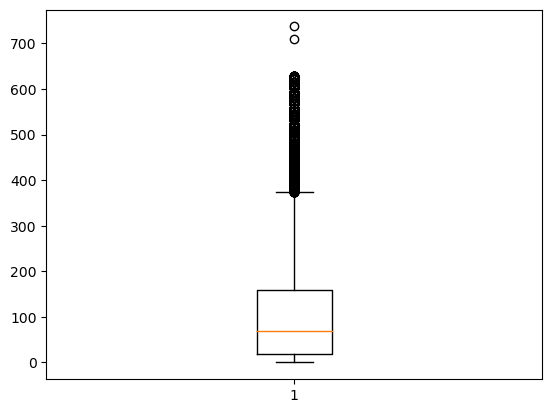

In [116]:
# checking dispersion of lead_time
plt.boxplot(df.lead_time)
plt.show()

In [117]:
# checking rows where lead time is greater than 365
df[df.lead_time>365]

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
347,Resort Hotel,0,542,40,2,5,3,0.00,0,HB,GBR,Groups,TA/TO,0,0,0,A,C,1,No Deposit,253.00,NaN,0,Transient-Party,99.00,0,0,Check-Out,03-10-2016,2016-09-26
350,Resort Hotel,0,383,41,0,3,3,0.00,0,BB,GBR,Groups,TA/TO,0,0,0,A,C,1,No Deposit,315.00,NaN,0,Transient-Party,66.00,0,0,Check-Out,09-10-2016,2016-10-06
359,Resort Hotel,0,385,43,1,4,3,0.00,0,BB,GBR,Groups,Corporate,0,0,0,A,C,1,No Deposit,NaN,NaN,0,Transient-Party,79.00,0,0,Check-Out,24-10-2016,2016-10-19
1131,Resort Hotel,0,386,43,1,3,3,0.00,0,BB,GBR,Groups,Corporate,0,0,0,A,A,1,No Deposit,NaN,NaN,0,Transient-Party,79.00,0,1,Check-Out,24-10-2016,2016-10-20
1132,Resort Hotel,0,386,43,1,3,3,0.00,0,BB,GBR,Groups,Corporate,0,0,0,A,A,3,No Deposit,NaN,NaN,0,Transient-Party,79.00,0,1,Check-Out,24-10-2016,2016-10-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118855,City Hotel,0,457,34,0,2,1,0.00,0,HB,DEU,Offline TA/TO,TA/TO,0,0,0,A,A,2,No Deposit,6.00,NaN,0,Transient-Party,95.50,0,1,Check-Out,27-08-2017,2017-08-25
118858,City Hotel,0,457,34,0,2,1,0.00,0,HB,DEU,Offline TA/TO,TA/TO,0,0,0,A,A,2,No Deposit,6.00,NaN,0,Transient-Party,95.50,0,1,Check-Out,27-08-2017,2017-08-25
118877,City Hotel,0,518,34,2,1,1,0.00,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,229.00,NaN,0,Transient-Party,0.00,0,0,Check-Out,29-08-2017,2017-08-26
119104,City Hotel,1,381,52,1,2,0,2.00,0,BB,DEU,Online TA,TA/TO,0,0,0,B,B,0,No Deposit,9.00,NaN,0,Transient,69.50,0,1,Canceled,23-12-2015,2016-12-23


In [118]:
# removing data points where lead_time is greater than 365 days
df = df[df['lead_time']<=365].copy()

In [119]:
# checking nulls
df.isna().sum()

df.drop(['agent','company'],axis=1,inplace=True)
df = df[~df.children.isna()]
df = df[~df.country.isna()].copy()

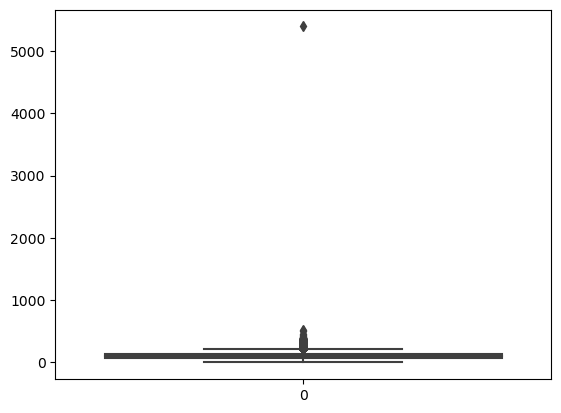

In [120]:
# checking dispersion of adr
sns.boxplot(df.adr)
plt.show()

In [121]:
print("Max adr:",np.max(df.adr))

Max adr: 5400.0


In [122]:
df = df[df.adr < np.max(df.adr)].copy()

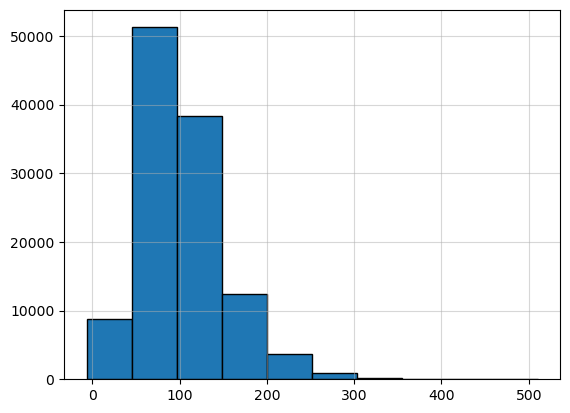

In [123]:
# sns.boxplot(df.adr)
plt.hist(df.adr,bins=10,edgecolor='black')
plt.grid(alpha=0.5)
plt.show()

In [124]:
print('Bookings where adr is greater than 300:', len(df[df.adr > 300]))

Bookings where adr is greater than 300: 273


In [ ]:
df = df[df.adr <= 300].copy()

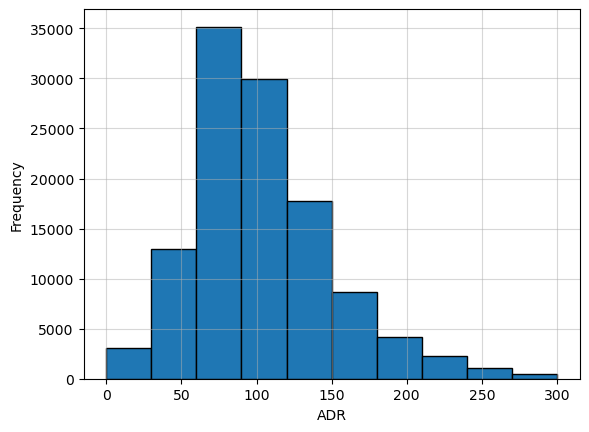

In [184]:
plt.hist(df.adr,bins=10,edgecolor='black')
plt.xlabel('ADR')
plt.ylabel('Frequency')
plt.grid(alpha=0.5)
plt.show()

In [126]:
# considering bookings where ADR is greater than 0
df = df[df['adr']>=0].copy()

# checking nulls 
df.isna().sum()

print("1st recorded date:",np.min(df['arrival_date'].dt.date))
print("last recorded date:",np.max(df['arrival_date'].dt.date))

print("Number of days between first and last recorded date:",(np.max(df['arrival_date'])-np.min(df['arrival_date'])).days)

# We have 792 days worth of data

df.rename(columns={'adults':'sum_guests'},inplace=True)

df.groupby('arrival_date')['sum_guests'].sum().reset_index()

1st recorded date: 2015-07-01
last recorded date: 2017-08-31
Number of days between first and last recorded date: 792


,arrival_date,sum_guests
0,2015-07-01,216
1,2015-07-02,186
2,2015-07-03,110
3,2015-07-04,171
4,2015-07-05,103
...,...,...
788,2017-08-27,332
789,2017-08-28,351
790,2017-08-29,205
791,2017-08-30,174


C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


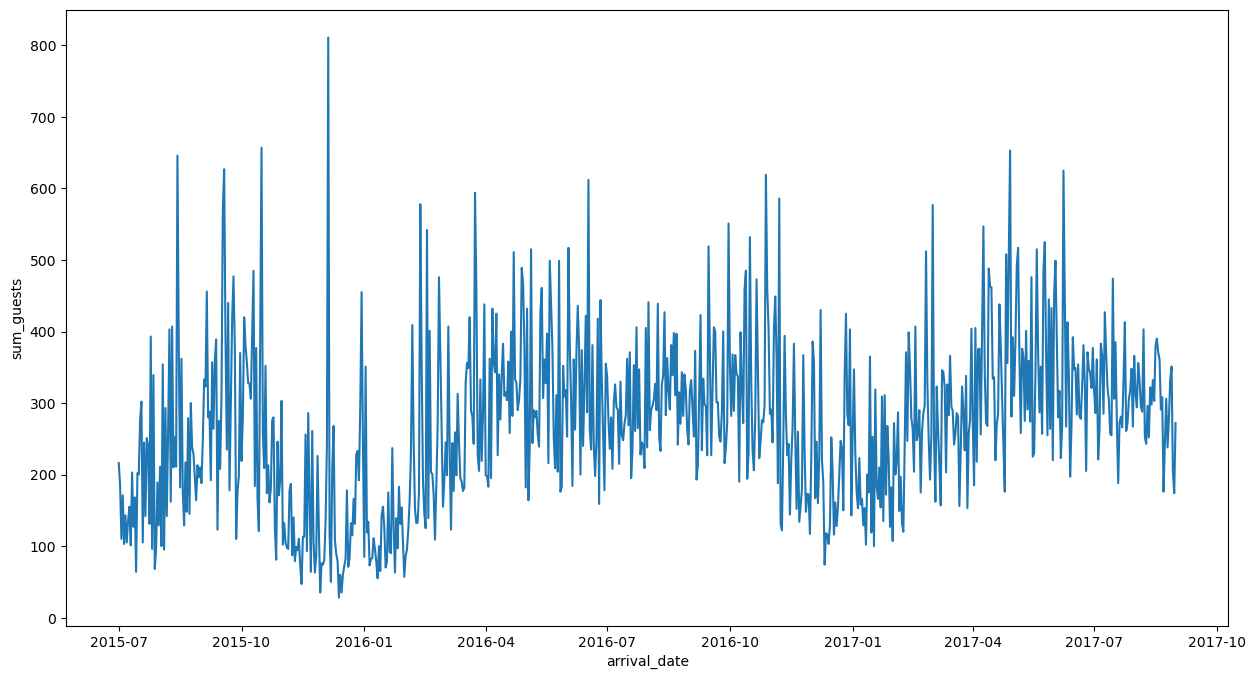

In [127]:
viz = df.groupby('arrival_date')['sum_guests'].sum().reset_index()

plt.figure(figsize=(15,8))
sns.lineplot(data=viz,x='arrival_date',y='sum_guests')
plt.show()

In [128]:
df['booking_date'] = df['arrival_date'] - pd.to_timedelta(df['lead_time'], unit='D')

In [129]:
# country to binary
df['country'] = df.country.apply(lambda x: 'domestic' if x == 'PRT' else 'international')

In [130]:
# meal
df['meal'] = df['meal'].apply(lambda x: 'BB' if x == 'BB' else 'Other Meal')

In [131]:
# market_segments
df['market_segment'] = df['market_segment'].apply(lambda x: 'Others'\
                                                  if x in ['Direct','Corporate','Complementary','Aviation'] else x)

# df.distribution_channel.value_counts()
df.drop('distribution_channel',axis=1,inplace=True)

# df.reserved_room_type.value_counts(normalize=True)
df.reserved_room_type = df.reserved_room_type.apply(lambda x: 'NotRoomTypeA' if x != 'A' else 'RoomTypeA')

print(df[(df.lead_time > 30)&(df.lead_time < 61)&(df.arrival_date=='2015-07-01')&(df.hotel=='Resort Hotel')].shape)
print(df[(df.lead_time < 31)&(df.arrival_date=='2015-07-01')&(df.hotel=='Resort Hotel')].shape)
print(df[(df.lead_time > 90)&(df.arrival_date=='2015-07-01')&(df.hotel=='Resort Hotel')].shape)

# bucketing lead times
df['lead_time'] = pd.cut(x=df['lead_time'],bins=[-1,30,90,1000],labels=['lt_0-30','lt_31-90','lt_91+'])

# assuming assigned room type as room reallocation as per availablility therefore removing this
df.drop(['assigned_room_type','deposit_type','reservation_status_date','arrival_date_week_number',\
            'reservation_status','booking_date'],axis=1,inplace=True)

# bookings = b0 + b1*leadTime + b2*sum_guests + b3*

dummies = pd.get_dummies(df,drop_first=True)
df = dummies.copy()
df.rename(columns={'hotel_Resort Hotel':'hotel'},inplace=True)

df.hotel = df.hotel.apply(lambda x: 'Resort Hotel' if x == 1 else 'City Hotel')

# Dividing into Resort Hotel and City Hotel

resorthotel = df[df.hotel == 'Resort Hotel'].copy()

# INTERPRETATION: 
# at Lead Time 28 3 guests came
# at Lead Time 27 5 guests came
# at Lead Time 26 2 guests came and so on

(6, 28)
(12, 28)
(11, 28)


In [132]:
df

,is_canceled,stays_in_weekend_nights,stays_in_week_nights,sum_guests,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date,hotel,lead_time_lt_31-90,lead_time_lt_91+,meal_Other Meal,country_international,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Others,reserved_room_type_RoomTypeA,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,2,0,55,0.00,0,0,0,0,0,0,0.00,0,0,2015-10-04,Resort Hotel,False,True,True,False,False,False,True,True,True,False,False
1,1,1,2,50,0.00,0,0,0,0,0,0,0.00,0,0,2015-09-07,Resort Hotel,False,True,False,False,False,False,True,True,True,False,False
2,1,0,3,40,0.00,0,0,0,0,0,0,0.00,0,0,2015-09-03,Resort Hotel,False,True,False,False,False,False,True,True,True,False,False
3,1,1,3,27,0.00,0,0,0,0,0,0,0.00,0,0,2015-09-21,Resort Hotel,False,True,True,False,False,False,True,True,True,False,False
4,1,1,3,27,0.00,0,0,0,0,0,0,0.00,0,0,2015-09-24,Resort Hotel,False,True,True,False,False,False,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,1,3,0,2.00,0,0,0,0,0,0,98.85,0,1,2017-07-27,City Hotel,False,True,False,True,False,True,False,False,False,True,False
119386,0,2,1,0,2.00,0,0,0,0,1,0,93.64,0,2,2017-07-30,City Hotel,False,True,False,True,False,True,False,False,False,True,False
119387,0,2,2,0,2.00,0,0,0,0,0,0,98.85,0,1,2017-07-29,City Hotel,False,True,False,False,False,True,False,False,False,True,False
119388,0,1,3,0,2.00,0,0,0,0,1,0,121.88,0,1,2017-07-31,City Hotel,False,True,True,True,False,True,False,True,False,True,False


In [133]:
resorthotel['is_canceled'].value_counts(normalize=True)

is_canceled
0   0.72
1   0.28
Name: proportion, dtype: float64

In [134]:
resorthotel.describe()

,is_canceled,stays_in_weekend_nights,stays_in_week_nights,sum_guests,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
count,38920.00,38920.00,38920.00,38920.00,38920.00,38920.00,38920.00,38920.00,38920.00,38920.00,38920.00,38920.00,38920.00,38920.00,38920
mean,0.28,1.20,3.13,1.87,0.13,0.01,0.05,0.10,0.13,0.29,0.53,94.32,0.14,0.62,2016-08-14 08:05:05.611510784
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015-07-01 00:00:00
25%,0.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.44,0.00,0.00,2016-02-13 00:00:00
50%,0.00,1.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,76.00,0.00,0.00,2016-08-16 00:00:00
75%,1.00,2.00,5.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,125.00,0.00,1.00,2017-03-05 00:00:00
max,1.00,16.00,40.00,55.00,10.00,2.00,1.00,26.00,30.00,17.00,185.00,300.00,8.00,5.00,2017-08-31 00:00:00
std,0.45,1.14,2.45,0.70,0.44,0.12,0.21,1.35,0.94,0.73,7.49,59.11,0.35,0.81,NaN


In [135]:
resorthotel[resorthotel.is_canceled==0].describe()

,is_canceled,stays_in_weekend_nights,stays_in_week_nights,sum_guests,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
count,28123.00,28123.00,28123.00,28123.00,28123.00,28123.00,28123.00,28123.00,28123.00,28123.00,28123.00,28123.00,28123.00,28123.00,28123
mean,0.00,1.14,3.01,1.84,0.10,0.02,0.06,0.01,0.17,0.34,0.70,90.15,0.19,0.67,2016-08-06 07:49:44.532233216
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015-07-01 00:00:00
25%,0.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,48.50,0.00,0.00,2016-02-06 00:00:00
50%,0.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,73.00,0.00,0.00,2016-08-08 00:00:00
75%,0.00,2.00,5.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,118.05,0.00,1.00,2017-02-20 00:00:00
max,0.00,16.00,40.00,4.00,3.00,2.00,1.00,5.00,30.00,17.00,185.00,300.00,8.00,5.00,2017-08-31 00:00:00
std,0.00,1.14,2.43,0.46,0.39,0.13,0.24,0.10,1.07,0.77,8.61,56.91,0.40,0.83,NaN


In [136]:
c1 = resorthotel[resorthotel.is_canceled==0].describe()

# stays_in_weekend_nights, stays_in_week_nights, 

resorthotel[resorthotel.is_canceled==1].describe()

c2 = resorthotel[resorthotel.is_canceled==1].describe()

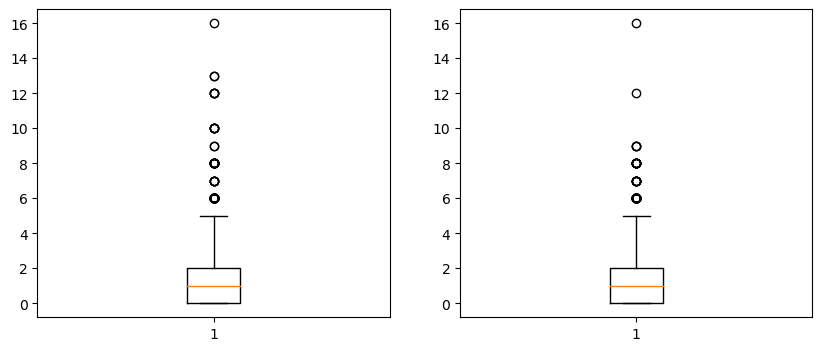

In [137]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.boxplot(resorthotel[resorthotel['is_canceled']==0]['stays_in_weekend_nights'])
plt.subplot(1,2,2)
plt.boxplot(resorthotel[resorthotel['is_canceled']==1]['stays_in_weekend_nights'])
plt.show()

In [138]:
resorthotel = resorthotel[resorthotel.stays_in_weekend_nights <= 5].copy()

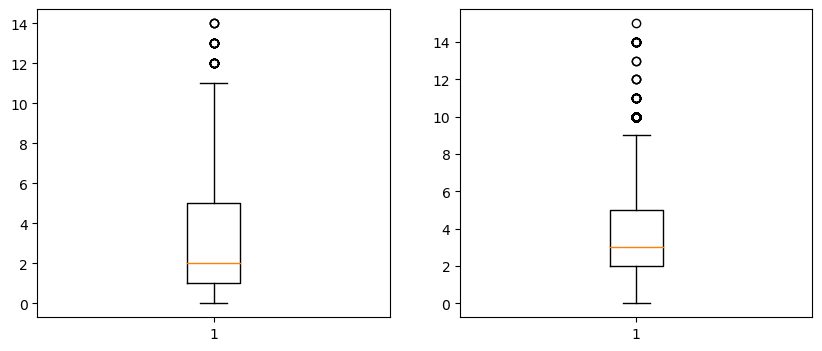

In [139]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.boxplot(resorthotel[resorthotel['is_canceled']==0]['stays_in_week_nights'])
plt.subplot(1,2,2)
plt.boxplot(resorthotel[resorthotel['is_canceled']==1]['stays_in_week_nights'])
plt.show()

In [140]:
resorthotel = resorthotel[resorthotel.stays_in_weekend_nights <= 11].copy()
resorthotel.describe()

,is_canceled,stays_in_weekend_nights,stays_in_week_nights,sum_guests,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
count,38742.00,38742.00,38742.00,38742.00,38742.00,38742.00,38742.00,38742.00,38742.00,38742.00,38742.00,38742.00,38742.00,38742.00,38742
mean,0.28,1.17,3.07,1.87,0.13,0.01,0.05,0.10,0.13,0.29,0.54,94.47,0.14,0.62,2016-08-14 04:54:38.302617344
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015-07-01 00:00:00
25%,0.00,0.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.52,0.00,0.00,2016-02-13 00:00:00
50%,0.00,1.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,76.00,0.00,0.00,2016-08-15 00:00:00
75%,1.00,2.00,5.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,125.00,0.00,1.00,2017-03-05 00:00:00
max,1.00,5.00,15.00,55.00,10.00,2.00,1.00,26.00,30.00,16.00,185.00,300.00,8.00,5.00,2017-08-31 00:00:00
std,0.45,1.07,2.22,0.70,0.44,0.12,0.21,1.36,0.94,0.71,7.50,59.17,0.35,0.81,NaN


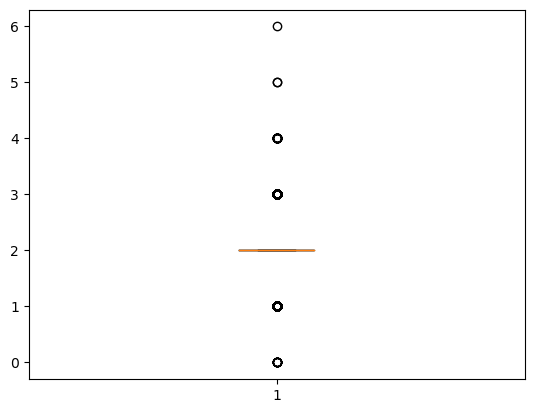

In [141]:
plt.boxplot(resorthotel[resorthotel['sum_guests'] < 10]['sum_guests'])
plt.show()

In [142]:
resorthotel.sum_guests.sort_values().tail(15)
resorthotel = resorthotel[resorthotel.sum_guests < 5].copy()
resorthotel = resorthotel[resorthotel['children'] < 3].copy()
resorthotel.drop(['children','babies'],axis=1,inplace=True)
resorthotel['total_of_special_requests'] = resorthotel['total_of_special_requests'].apply(lambda x: 'Greater Than 0 requests' if x > 0 else '0 requests')
resorthotel.drop(['is_repeated_guest','previous_cancellations','previous_bookings_not_canceled',\
                  'booking_changes','days_in_waiting_list','required_car_parking_spaces',\
                 'meal_Other Meal'],axis=1,inplace=True)

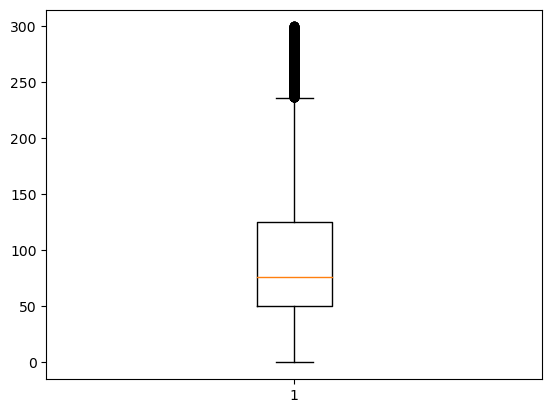

In [143]:
plt.boxplot(resorthotel.adr)
plt.show()

In [144]:
resorthotel[resorthotel.adr == 0]
resorthotel[resorthotel.adr != 0 ].sort_values(by='adr')
resorthotel = resorthotel[resorthotel.adr != 0 ].copy()
resorthotel.country_international.sum()
resorthotel.country_international.value_counts(normalize=True)
resorthotel['market_segment_Offline TA/TO'].value_counts(normalize=True)
resorthotel['market_segment_Online TA'].value_counts(normalize=True)
resorthotel['market_segment_Others'].value_counts(normalize=True)
resorthotel['reserved_room_type_RoomTypeA'].value_counts(normalize=True)
resorthotel['customer_type_Group'].value_counts(normalize=True)
resorthotel.drop('customer_type_Group',axis=1,inplace=True)
resorthotel['customer_type_Transient'].value_counts(normalize=True)
resorthotel['customer_type_Transient-Party'].value_counts(normalize=True)
resorthotel['lead_time_lt_31-90'].value_counts(normalize=True)
resorthotel['lead_time_lt_91+'].value_counts(normalize=True)
resorthotel['DoW'] = resorthotel['arrival_date'].dt.day_name()
resorthotel['Month'] = resorthotel['arrival_date'].dt.month_name()
resorthotel['DoW'].value_counts(normalize=True)
resorthotel['Month'].value_counts(normalize=True)

Month
August      0.12
July        0.12
April       0.09
May         0.09
October     0.08
March       0.08
June        0.08
February    0.08
September   0.08
December    0.06
November    0.06
January     0.05
Name: proportion, dtype: float64

In [145]:
dummies_dow = pd.get_dummies(resorthotel['DoW'],drop_first=True)
dummies_month = pd.get_dummies(resorthotel['Month'],drop_first=True)
dummies_all = pd.concat([dummies_dow,dummies_month],axis=1)

resorthotel = pd.concat([resorthotel,dummies_all],axis=1)
resorthotel.drop(['arrival_date','DoW','Month'],axis=1,inplace=True)
resorthotel.drop('hotel',axis=1,inplace=True)

dummies_spec = pd.get_dummies(resorthotel['total_of_special_requests'],drop_first=True)

resorthotel = pd.concat([resorthotel,dummies_spec],axis=1)
resorthotel.drop('total_of_special_requests',axis=1,inplace=True)

# Train-Test Split

In [146]:
x = resorthotel.drop('is_canceled',axis=1)
y = resorthotel['is_canceled']

x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=10)

print(y_train.mean())
print(y_test.mean())

0.2816859044253111
0.27578947368421053


In [147]:
x_test_summary = x_test.copy()

# standardize
scaler = StandardScaler()

numeric_columns = x_train.columns

# Scale selected columns in the DataFrame
x_train[numeric_columns] = scaler.fit_transform(x_train[numeric_columns])

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
# running RFE with 15 variables as output
rfe = RFE(logreg)             
rfe = rfe.fit(x_train, y_train)

rfe

RFE(estimator=LogisticRegression())

In [148]:
# Viewing columns selected by RFE
cols = x_train.columns[rfe.support_]
print(cols)

Index(['stays_in_week_nights', 'adr', 'lead_time_lt_31-90', 'lead_time_lt_91+',
       'country_international', 'market_segment_Offline TA/TO',
       'market_segment_Others', 'customer_type_Transient',
       'customer_type_Transient-Party', 'Monday', 'Tuesday', 'Wednesday',
       'August', 'July', 'Greater Than 0 requests'],
      dtype='object')


In [149]:
list(zip(x_train.columns, rfe.support_, rfe.ranking_))

[('stays_in_weekend_nights', False, 5),
 ('stays_in_week_nights', True, 1),
 ('sum_guests', False, 10),
 ('adr', True, 1),
 ('lead_time_lt_31-90', True, 1),
 ('lead_time_lt_91+', True, 1),
 ('country_international', True, 1),
 ('market_segment_Offline TA/TO', True, 1),
 ('market_segment_Online TA', False, 17),
 ('market_segment_Others', True, 1),
 ('reserved_room_type_RoomTypeA', False, 14),
 ('customer_type_Transient', True, 1),
 ('customer_type_Transient-Party', True, 1),
 ('Monday', True, 1),
 ('Saturday', False, 12),
 ('Sunday', False, 6),
 ('Thursday', False, 13),
 ('Tuesday', True, 1),
 ('Wednesday', True, 1),
 ('August', True, 1),
 ('December', False, 4),
 ('February', False, 7),
 ('January', False, 2),
 ('July', True, 1),
 ('June', False, 15),
 ('March', False, 3),
 ('May', False, 8),
 ('November', False, 11),
 ('October', False, 9),
 ('September', False, 16),
 ('Greater Than 0 requests', True, 1)]

# fitting the model

In [150]:
x_train_sm = sm.add_constant(x_train[cols])
logm1 = sm.GLM(y_train,x_train_sm, family = sm.families.Binomial())
result = logm1.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            is_canceled   No. Observations:                26597
Model:                            GLM   Df Residuals:                    26581
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11377.
Date:                Fri, 23 Aug 2024   Deviance:                       22754.
Time:                        23:29:18   Pearson chi2:                 2.77e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2836
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.3578      0.019    -71.744      0.000      -1.395      -1.321
stays_in_week_nights              0.1364      0.020      6.874      0.000       0.097       0.175
adr                               0.2343      0.024      9.643      0.000       0.187       0.282
lead_time_lt_31-90                0.5906      0.020     29.076      0.000       0.551       0.630
lead_time_lt_91+                  0.9007      0.024     38.303      0.000       0.855       0.947
country_international            -0.9820      0.018    -53.612      0.000      -1.018      -0.946
market_segment_Offline TA/TO     -0.6613      0.022    -30.569      0.000      -0.704      -0.619
market_segment_Others            -0.7217      0.021    -34.890      0.000      -0.762      -0.681
customer_type_Transient           0.5007      0.051      9.751      0.000       0.400       0.601
customer_type_Transient-Party    -0.0965      0.050     -1.920      0.055      -0.195       0.002
Monday                           -0.1133      0.017     -6.537      0.000      -0.147      -0.079
Tuesday                          -0.0809      0.018     -4.597      0.000      -0.115      -0.046
Wednesday                        -0.1028      0.018     -5.839      0.000      -0.137      -0.068
August                           -0.1281      0.022     -5.713      0.000      -0.172      -0.084
July                             -0.1368      0.020     -6.877      0.000      -0.176      -0.098
Greater Than 0 requests          -0.5700      0.018    -30.986      0.000      -0.606      -0.534
=================================================================================================
"""

In [151]:
new_cols = x_train[cols].copy()

new_cols.drop('customer_type_Transient-Party',axis=1,inplace=True)

x_train_2 = sm.add_constant(new_cols)
logm1 = sm.GLM(y_train,x_train_2, family = sm.families.Binomial())
result = logm1.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            is_canceled   No. Observations:                26597
Model:                            GLM   Df Residuals:                    26582
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11379.
Date:                Fri, 23 Aug 2024   Deviance:                       22757.
Time:                        23:29:18   Pearson chi2:                 2.76e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2835
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.3606      0.019    -71.927      0.000      -1.398      -1.324
stays_in_week_nights             0.1410      0.020      7.159      0.000       0.102       0.180
adr                              0.2343      0.024      9.645      0.000       0.187       0.282
lead_time_lt_31-90               0.5879      0.020     29.040      0.000       0.548       0.628
lead_time_lt_91+                 0.8965      0.023     38.352      0.000       0.851       0.942
country_international           -0.9799      0.018    -53.628      0.000      -1.016      -0.944
market_segment_Offline TA/TO    -0.6494      0.021    -31.450      0.000      -0.690      -0.609
market_segment_Others           -0.7190      0.021    -34.864      0.000      -0.759      -0.679
customer_type_Transient          0.5925      0.020     29.748      0.000       0.553       0.631
Monday                          -0.1137      0.017     -6.563      0.000      -0.148      -0.080
Tuesday                         -0.0816      0.018     -4.639      0.000      -0.116      -0.047
Wednesday                       -0.1038      0.018     -5.900      0.000      -0.138      -0.069
August                          -0.1274      0.022     -5.680      0.000      -0.171      -0.083
July                            -0.1355      0.020     -6.811      0.000      -0.174      -0.097
Greater Than 0 requests         -0.5671      0.018    -30.958      0.000      -0.603      -0.531
================================================================================================
"""

In [152]:
# Getting the predicted values on the train set
y_train_pred = result.predict(x_train_2)
y_train_pred[:10]

26168    0.08
100550   0.12
9460     0.27
10895    0.17
29483    0.14
97708    0.16
25276    0.06
99915    0.03
100418   0.02
33716    0.20
dtype: float64

In [153]:
# Reshaping into an array
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.08054312, 0.1169726 , 0.27294498, 0.1717582 , 0.14035134,
       0.15531841, 0.06051551, 0.027462  , 0.02162268, 0.20217241])

In [154]:
y_train_pred_final = pd.DataFrame({'Cancelled':y_train.values, 'Cancelled_prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Cancelled,Cancelled_prob,CustID
0,0,0.08,26168
1,0,0.12,100550
2,1,0.27,9460
3,1,0.17,10895
4,0,0.14,29483


In [155]:
y_train_pred_final['predicted'] = y_train_pred_final.Cancelled_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Cancelled,Cancelled_prob,CustID,predicted
0,0,0.08,26168,0
1,0,0.12,100550,0
2,1,0.27,9460,0
3,1,0.17,10895,0
4,0,0.14,29483,0


In [156]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Cancelled, y_train_pred_final.predicted )
print(confusion)

[[17403  1702]
 [ 3186  4306]]


In [157]:
# Let's check the overall accuracy.
print('Accuracy :',metrics.accuracy_score(y_train_pred_final.Cancelled, y_train_pred_final.predicted))

Accuracy : 0.8162198744219273


In [158]:
col1 = new_cols.columns

vif = pd.DataFrame()
vif['Features'] = x_train[col1].columns
vif['VIF'] = [variance_inflation_factor(x_train[col1].values, i) for i in range(x_train[col1].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,adr,2.34
11,August,1.96
3,lead_time_lt_91+,1.74
12,July,1.51
0,stays_in_week_nights,1.43
2,lead_time_lt_31-90,1.40
5,market_segment_Offline TA/TO,1.25
6,market_segment_Others,1.25
4,country_international,1.12
7,customer_type_Transient,1.11


In [159]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Sensitivity of our logistic regression model
print("Sensitivity : ",TP / float(TP+FN))

# Let us calculate specificity
print("Specificity : ",TN / float(TN+FP))

# Calculate false postive rate - predicting converted lead when the lead actually was not converted
print("False Positive Rate :",FP/ float(TN+FP))

# positive predictive value 
print("Positive Predictive Value :",TP / float(TP+FP))

# Negative predictive value
print("Negative predictive value :",TN / float(TN+FN))

Sensitivity :  0.5747463961558996
Specificity :  0.9109133734624444
False Positive Rate : 0.08908662653755561
Positive Predictive Value : 0.716711051930759
Negative predictive value : 0.8452571761620282


In [160]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

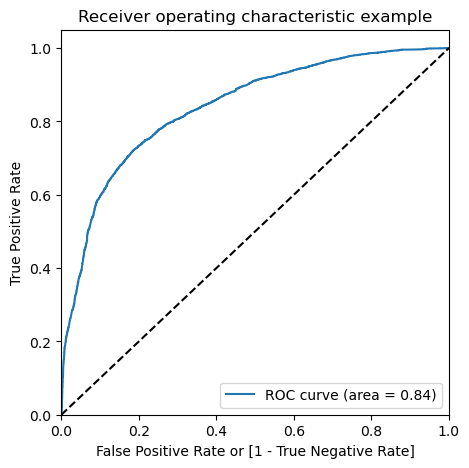

In [161]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final.Cancelled, y_train_pred_final.Cancelled_prob, drop_intermediate = False)

draw_roc(y_train_pred_final.Cancelled, y_train_pred_final.Cancelled_prob)

In [162]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Cancelled_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Cancelled, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy  sensi  speci
0.00  0.00      0.28   1.00   0.00
0.10  0.10      0.55   0.94   0.40
0.20  0.20      0.70   0.84   0.65
0.30  0.30      0.79   0.71   0.82
0.40  0.40      0.81   0.64   0.88
0.50  0.50      0.82   0.57   0.91
0.60  0.60      0.80   0.41   0.95
0.70  0.70      0.78   0.28   0.97
0.80  0.80      0.77   0.19   0.99
0.90  0.90      0.73   0.04   1.00


In [163]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/100 for x in range(20,30)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Cancelled_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Cancelled, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy  sensi  speci
0.21  0.21      0.71   0.82   0.67
0.22  0.22      0.73   0.81   0.69
0.23  0.23      0.74   0.80   0.72
0.24  0.24      0.75   0.78   0.74
0.25  0.25      0.76   0.77   0.75
0.26  0.26      0.77   0.76   0.77
0.27  0.27      0.77   0.74   0.79
0.28  0.28      0.78   0.73   0.80
0.29  0.29      0.79   0.72   0.81


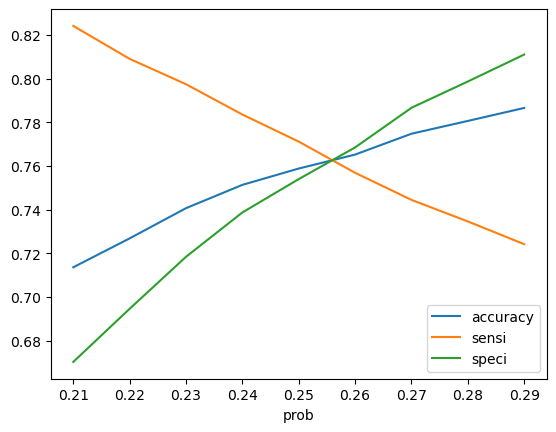

In [164]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [165]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Cancelled_prob.map(lambda x: 1 if x > 0.26 else 0)
y_train_pred_final.head()

,Cancelled,Cancelled_prob,CustID,predicted,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,final_predicted
0,0,0.08,26168,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0.12,100550,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0.27,9460,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1
3,1,0.17,10895,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.14,29483,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [166]:
y_train_pred_final['Cancellation_Score'] = y_train_pred_final.Cancelled_prob.map(lambda x: round(x*100))
y_train_pred_final.head()

,Cancelled,Cancelled_prob,CustID,predicted,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,final_predicted,Cancellation_Score
0,0,0.08,26168,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,0,0.12,100550,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12
2,1,0.27,9460,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,27
3,1,0.17,10895,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
4,0,0.14,29483,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14


In [167]:
## Model Evaluation 

# Let's check the overall accuracy.
print("Accuracy :",metrics.accuracy_score(y_train_pred_final.Cancelled, y_train_pred_final.final_predicted))

Accuracy : 0.7652742790540287


In [168]:
# Confusion matrix
confusion2 = metrics.confusion_matrix(y_train_pred_final.Cancelled, y_train_pred_final.final_predicted )
confusion2

array([[14683,  4422],
       [ 1821,  5671]], dtype=int64)

In [169]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print("Sensitivity : ",TP / float(TP+FN))

# Let us calculate specificity
print("Specificity :",TN / float(TN+FP))

# Calculate false postive rate - predicting Cancelled lead when the lead was actually not have Cancelled
print("False Positive rate : ",FP/ float(TN+FP))

# Positive predictive value 
print("Positive Predictive Value :",TP / float(TP+FP))

# Negative predictive value
print("Negative Predictive Value : ",TN / float(TN+ FN))

Sensitivity :  0.756940736785905
Specificity : 0.7685422664224025
False Positive rate :  0.2314577335775975
Positive Predictive Value : 0.5618745665312593
Negative Predictive Value :  0.8896631119728551


In [170]:
## Making predictions on the test set

### Scaling the test data

x_test[numeric_columns] = scaler.transform(x_test[numeric_columns])

# Assigning the columns selected by the final model to the x_test 
x_test = x_test[col1]
x_test.head()

,stays_in_week_nights,adr,lead_time_lt_31-90,lead_time_lt_91+,country_international,market_segment_Offline TA/TO,market_segment_Others,customer_type_Transient,Monday,Tuesday,Wednesday,August,July,Greater Than 0 requests
27133,-0.04,0.33,-0.54,1.23,0.88,2.07,-0.52,0.56,2.32,-0.37,-0.37,2.66,-0.36,-0.90
19244,0.41,0.89,-0.54,1.23,0.88,2.07,-0.52,0.56,-0.43,-0.37,-0.37,-0.38,2.77,1.11
17999,-0.95,0.74,-0.54,-0.81,-1.13,-0.48,1.91,0.56,2.32,-0.37,-0.37,-0.38,-0.36,1.11
31200,-0.95,-0.72,-0.54,-0.81,-1.13,-0.48,1.91,0.56,-0.43,-0.37,2.72,-0.38,-0.36,-0.90
26192,0.86,-0.21,-0.54,1.23,0.88,2.07,-0.52,-1.77,-0.43,-0.37,-0.37,-0.38,-0.36,-0.90


In [171]:
# Adding a const
x_test_sm = sm.add_constant(x_test)

# Making predictions on the test set
y_test_pred = result.predict(x_test_sm)
y_test_pred[:10]

# Converting y_test_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

# Let's see the head
y_pred_1.head()

,0
27133,0.12
19244,0.07
17999,0.06
31200,0.13
26192,0.07


In [172]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

# Putting Prospect ID to index
y_test_df['CustID'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

y_pred_final.head()

,is_canceled,CustID,0
0,0,27133,0.12
1,0,19244,0.07
2,0,17999,0.06
3,0,31200,0.13
4,0,26192,0.07


In [173]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Cancelled_prob'})

y_pred_final.rename(columns={'is_canceled':'Cancelled'},inplace=True)

# Rearranging the columns
y_pred_final = y_pred_final.reindex(columns=['CustID','Cancelled','Cancelled_prob'])

# Let's see the head of y_pred_final
y_pred_final.head()

,CustID,Cancelled,Cancelled_prob
0,27133,0,0.12
1,19244,0,0.07
2,17999,0,0.06
3,31200,0,0.13
4,26192,0,0.07


In [174]:
y_pred_final['final_predicted'] = y_pred_final.Cancelled_prob.map(lambda x: 1 if x > 0.26 else 0)

y_pred_final.head()

,CustID,Cancelled,Cancelled_prob,final_predicted
0,27133,0,0.12,0
1,19244,0,0.07,0
2,17999,0,0.06,0
3,31200,0,0.13,0
4,26192,0,0.07,0


In [175]:
# Let's check the overall accuracy.
print("Accuracy :",metrics.accuracy_score(y_pred_final.Cancelled, y_pred_final.final_predicted))

# Making the confusion matrix
confusion2 = metrics.confusion_matrix(y_pred_final.Cancelled, y_pred_final.final_predicted )
confusion2

Accuracy : 0.7625438596491229


array([[6323, 1933],
       [ 774, 2370]], dtype=int64)

In [176]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print("Sensitivity :",TP / float(TP+FN))

# Let us calculate specificity
print("Specificity :",TN / float(TN+FP))

### Assigning Lead Score to the Testing data

y_pred_final['Cancellation_Score'] = y_pred_final.Cancelled_prob.map( lambda x: round(x*100))

y_pred_final.head()

Sensitivity : 0.7538167938931297
Specificity : 0.7658672480620154


,CustID,Cancelled,Cancelled_prob,final_predicted,Cancellation_Score
0,27133,0,0.12,0,12
1,19244,0,0.07,0,7
2,17999,0,0.06,0,6
3,31200,0,0.13,0,13
4,26192,0,0.07,0,7


#### Train set result

- Accuracy : 0.7652742790540287
- Sensitivity :  0.756940736785905
- Specificity : 0.7685422664224025

#### Test set result

- Accuracy : 0.7625438596491229
- Sensitivity : 0.7538167938931297
- Specificity : 0.7658672480620154

In [177]:
# objective: calculate cancellation rate
# calculate expected revenue from cancellations

# Euros 100 
# cancellation charge; 20%

print('Total cancellations:', y_pred_final.final_predicted.sum())
print('Total booking ID:', y_pred_final.shape[0])
print('Cancellation rate:', round(100 * y_pred_final.final_predicted.mean(),2))

Total cancellations: 4303
Total booking ID: 11400
Cancellation rate: 37.75


In [178]:
adr = x_test_summary['adr'].to_frame()
adr.reset_index(inplace=True)
adr.rename(columns={'index':'CustID'},inplace=True)

cancellation_final = y_pred_final.merge(adr,on='CustID',how='inner')

cancelled_bookings1 = cancellation_final[cancellation_final.final_predicted == 1].copy()

# scenario when we charge 20% on all cancellations

cancelled_bookings1['ExpectedRev'] = cancelled_bookings1['Cancelled_prob'] * cancelled_bookings1['adr'] * 0.2

print('Expected Revenue from cancellations:',round(cancelled_bookings1.ExpectedRev.sum(),0))

lead_time_df = raw_df.lead_time.to_frame()
lead_time_df.reset_index(inplace=True)
lead_time_df.rename(columns={'index':'CustID'},inplace=True)

cancellation_final = cancellation_final.merge(lead_time_df,how='inner',on='CustID')

Expected Revenue from cancellations: 54736.0


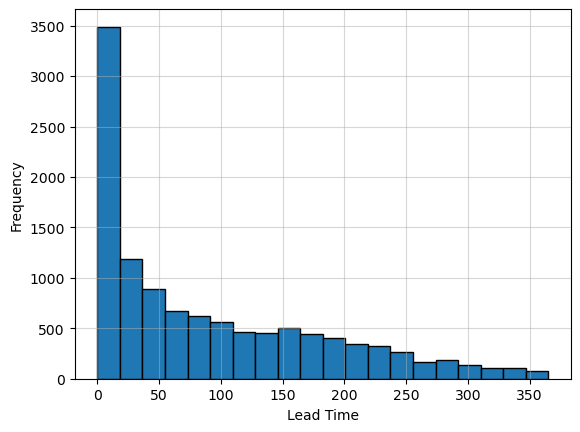

In [183]:
plt.hist(cancellation_final.lead_time,bins=20,edgecolor='black')
plt.grid(alpha=0.5)
plt.xlabel('Lead Time')
plt.ylabel('Frequency')
plt.show()

In [180]:
cancellation_final['lead_time_bucket'] = pd.cut(cancellation_final.lead_time,bins=25)
cancellation_final['lead_time_bucket'] = cancellation_final['lead_time_bucket'].astype('str')
cancellation_final['lead_time_bucket'] = cancellation_final.lead_time_bucket.str.replace('(','')
cancellation_final['lead_time_bucket'] = cancellation_final['lead_time_bucket'].str.replace(']','')

# if lead time bucket in 0-15, 50% cancellation
# if lead time bucket in 15-29, 25% cancellation

cancelled_bookings2 = cancellation_final[cancellation_final['final_predicted'] == 1].copy()

cancelled_bookings2['ExpectedRevenue'] = cancelled_bookings2['Cancelled_prob']*cancelled_bookings2['adr']

cancelled_bookings2['ExpectedRevenue2'] = cancelled_bookings2.loc[cancelled_bookings2['lead_time'] < 15,'ExpectedRevenue'] * 0.5
cancelled_bookings2['ExpectedRevenue2'] = cancelled_bookings2.loc[(cancelled_bookings2['lead_time'] >= 15)&(cancelled_bookings2['lead_time'] < 30),'ExpectedRevenue'] * 0.25
cancelled_bookings2['ExpectedRevenue2'] = cancelled_bookings2.loc[(cancelled_bookings2['lead_time'] >= 30)&(cancelled_bookings2['lead_time'] < 45),'ExpectedRevenue'] * 0.10
cancelled_bookings2['ExpectedRevenue2'] = cancelled_bookings2.loc[(cancelled_bookings2['lead_time'] >= 45)&(cancelled_bookings2['lead_time'] < 120),'ExpectedRevenue'] * 0.05
cancelled_bookings2['ExpectedRevenue2'] = cancelled_bookings2.loc[(cancelled_bookings2['lead_time'] >= 120),'ExpectedRevenue'] * 0


cancelled_bookings2.reset_index(drop=True,inplace=True)

cancelled_bookings2['ExpectedRevenue2'] = np.nan

def expected_revenue_func(row):
    if row['lead_time'] >= 0 and row['lead_time'] < 15:
        return row['ExpectedRevenue'] * 0.5
    elif row['lead_time'] >= 15 and row['lead_time'] < 30:
        return row['ExpectedRevenue'] * 0.25
    elif row['lead_time'] >= 30 and row['lead_time'] < 45:
        return row['ExpectedRevenue'] * 0.10
    elif row['lead_time'] >= 45 and row['lead_time'] < 120:
        return row['ExpectedRevenue'] *0.05
    else:
        return row['ExpectedRevenue'] * 0

cancelled_bookings2['ExpectedRevenue2'] = cancelled_bookings2.apply(expected_revenue_func,axis=1)

cancelled_bookings2.rename(columns={'ExpectedRevenue2':'FinalRevenue'},inplace=True)

print('Expected Final Revenue from Cancellations:',int(cancelled_bookings2.FinalRevenue.sum()))

Expected Final Revenue from Cancellations: 17095


The aim of adding a cancellation percentage based on lead time is get a tradeoff between customer satisfaction and additional revenue. Adding a 100% cancellation charge on all lead times would reduce customer satisfaction. But a 0% cancellation charge would lead to loss of revenue opportunities. Therefore, various thresholds have been set based on lead
time to arrive at an optimal decision matrix where there is a balance between customer satisfaction and revenue. 


In [181]:
cancelled_bookings2.drop('lead_time_bucket',axis=1,inplace=True)

In [182]:
cancelled_bookings2

,CustID,Cancelled,Cancelled_prob,final_predicted,Cancellation_Score,adr,lead_time,ExpectedRevenue,FinalRevenue
0,18879,0,0.60,1,60,119.70,172,72.36,0.00
1,88,0,0.85,1,85,225.00,44,192.19,19.22
2,10172,1,0.90,1,90,84.00,106,75.87,3.79
3,27018,0,0.34,1,34,237.67,5,80.64,40.32
4,102849,0,0.55,1,55,63.90,5,35.02,17.51
...,...,...,...,...,...,...,...,...,...
4298,35308,0,0.26,1,26,92.00,169,23.98,0.00
4299,11635,1,0.72,1,72,116.00,97,84.01,4.20
4300,35527,0,0.60,1,60,194.00,138,115.50,0.00
4301,19104,1,0.89,1,89,80.00,245,71.19,0.00


### End